In [1]:
import numpy as np
import pandas as pd
from aeon.forecasting.naive import NaiveForecaster
from aeon.visualisation import plot_series
import warnings
warnings.filterwarnings('ignore')

from utils import Pipeline

# Load && prepare dataset

In [2]:
train_df = pd.read_csv('../data/split/train_data.csv')
test_df = pd.read_csv('../data/split/test_data.csv')

In [3]:
train_df.head()

,timestamp,light_air,light_ground,moisture_ground,dht_air_humidity,dht_air_temperature,dht_ground_humidity,dht_ground_temperature
0,1697063380,2311,1999,944,40,24.4,40,24.3
1,1697063416,2325,2006,929,40,24.3,40,24.3
2,1697063450,2320,2003,952,40,24.3,40,24.3
3,1697063484,2329,1999,950,40,24.3,40,24.2
4,1697063518,2307,1983,961,40,24.3,40,24.2


In [4]:
pipe_train_df = Pipeline(train_df)
pipe_test_df = Pipeline(test_df)

In [5]:
train_df = pipe_train_df.process()
train_df.head()

[+] Total missing values: 483


,light_air,moisture_ground,dht_air_humidity,dht_air_temperature,dht_ground_humidity,dht_ground_temperature,timestamp
58,0.334191,0.430707,0.888325,0.647217,0.620567,0.712714,1697065281
59,0.368660,0.430777,0.868020,0.654399,0.606383,0.716381,1697065315
60,0.402906,0.430632,0.847716,0.661580,0.595745,0.720049,1697065350
61,0.436765,0.430221,0.827411,0.668761,0.581560,0.705990,1697065382
62,0.465946,0.429684,0.809137,0.649372,0.570213,0.710513,1697065417


In [6]:
test_df = pipe_test_df.process()
test_df.head()

[+] Total missing values: 169


,light_air,moisture_ground,dht_air_humidity,dht_air_temperature,dht_ground_humidity,dht_ground_temperature,timestamp
58,0.259790,0.359033,0.623529,0.165829,0.675325,0.021978,1697357869
59,0.239950,0.345544,0.611765,0.190955,0.649351,0.054945,1697357909
60,0.263029,0.322991,0.600000,0.211055,1.000000,0.082418,1697357943
61,0.188763,0.255226,0.588235,0.085427,0.961039,0.109890,1697357978
62,0.207879,0.241651,0.576471,0.105528,0.922078,0.137363,1697358011


In [29]:
y_train = train_df['moisture_ground']
X_train = train_df.drop('moisture_ground', axis=1)
y_test = test_df['moisture_ground']
X_test = test_df.drop('moisture_ground', axis=1)

# Forecasting

## Baseline

In [8]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def plot_and_validate(train, test, predictions):
    predictions_array = np.array(predictions)
    
    rmse = np.sqrt(mean_squared_error(test.values, predictions_array))
    print(f"Test RMSE: {rmse:.3f}")

    plt.figure(figsize=(18,6))
    # Plot train set
    plt.plot(train, label='Train Set')

    # Plot test set
    test_x = np.arange(len(train), len(train)+len(test))
    plt.plot(test_x, test, label='Test Set')
    plt.plot(test_x, predictions, label='Predictions')

    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Predictions vs Ground Truth')
    plt.legend()
    plt.show()

## Persistence Demonstration

Test RMSE: 0.211
Test RMSE: 0.211


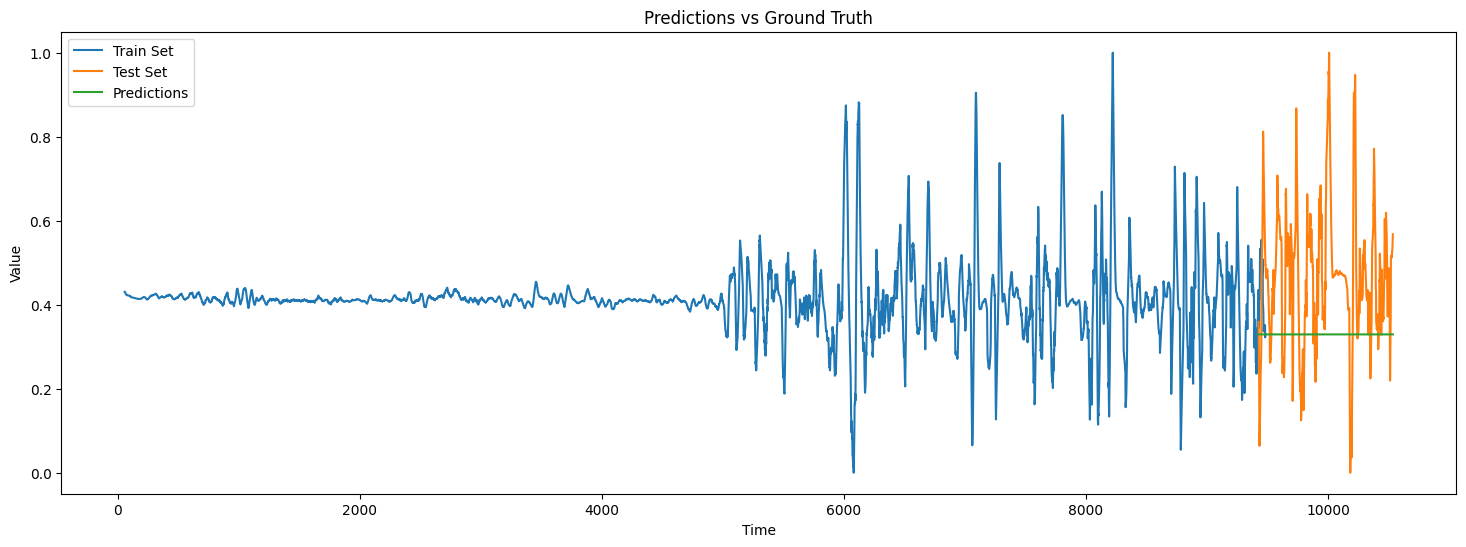

In [9]:
predictions = [y_train.values[-1]]*len(y_test)
rmse = np.sqrt(mean_squared_error(y_test.values, predictions))
print('Test RMSE: %.3f' % rmse)

# Plot train set
plot_and_validate(y_train, y_test, predictions)

## Simple Moving Average Demonstration

Test RMSE: 0.193


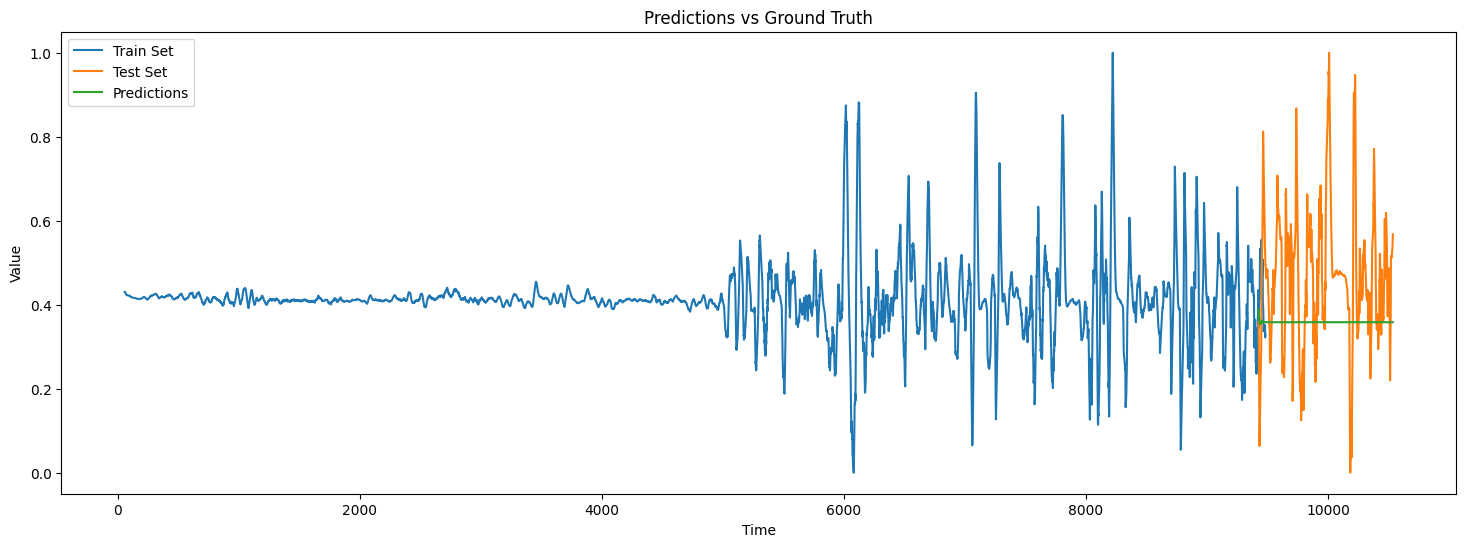

In [10]:
# Simple Moving Average model
def model_sma(history, window_size):
    return np.mean(history[-window_size:])

# Walk-forward validation for SMA
predictions_sma = list()
history = y_train.values.tolist()

for i in range(len(y_test)):
    # Predict and append to predictions
    yhat = model_sma(history, 30) # with 500 of window are a bit better
    predictions_sma.append(yhat)
    
    # Add actual observation to history for the next loop
    history.append(yhat)

plot_and_validate(y_train, y_test, predictions_sma)

## Exponential Smoothing Demonstration


Test RMSE: 0.193


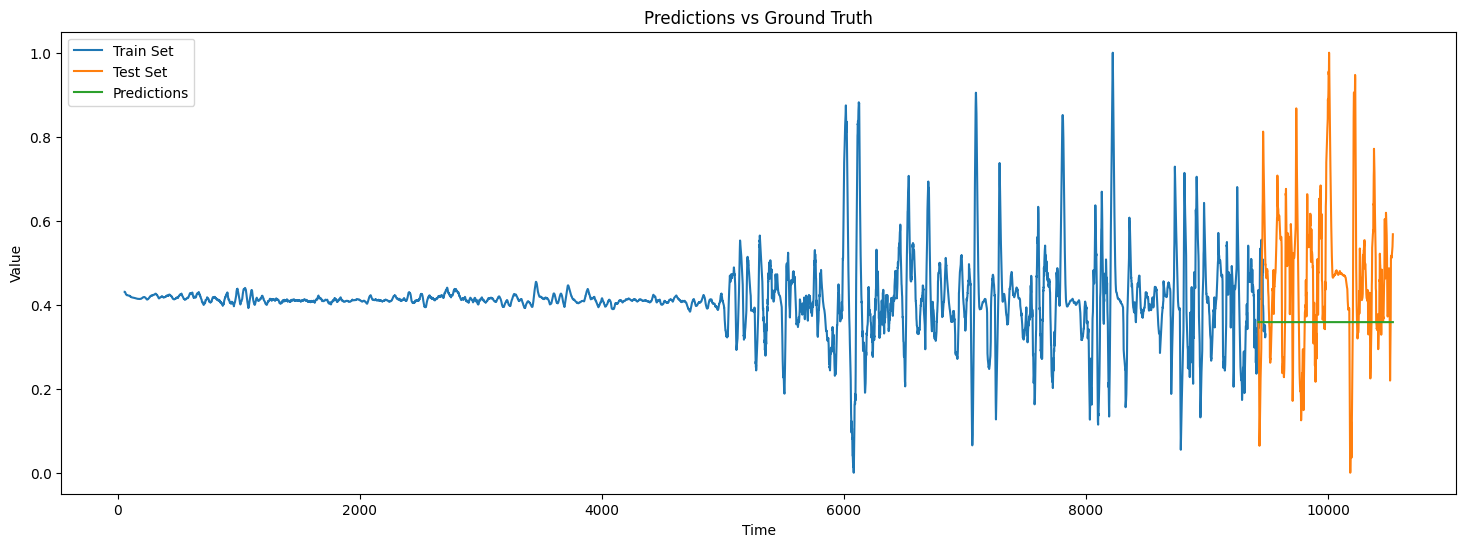

In [11]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from numpy import sqrt

# Fit the model
model = SimpleExpSmoothing(y_train.values)
model_fit = model.fit(smoothing_level=0.1, optimized=False)

# Make prediction
yhat = model_fit.forecast(len(y_test))

# Walk-forward validation for Exponential Smoothing
predictions_exp = list()
history = y_train.values.tolist()

for i in range(len(y_test)):
    # Predict and append to predictions
    yhat = model_fit.predict(len(history), len(history))
    predictions_exp.append(yhat)
    
    # Add actual observation to history for the next loop
    history.append(y_test.values[i])

plot_and_validate(y_train, y_test, predictions_exp)

## ARIMA and SARIMA Demonstration


c:\Users\Bl1tty\Documents\Uni\temporales\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Bl1tty\Documents\Uni\temporales\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Bl1tty\Documents\Uni\temporales\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Test RMSE: 1.316


c:\Users\Bl1tty\Documents\Uni\temporales\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


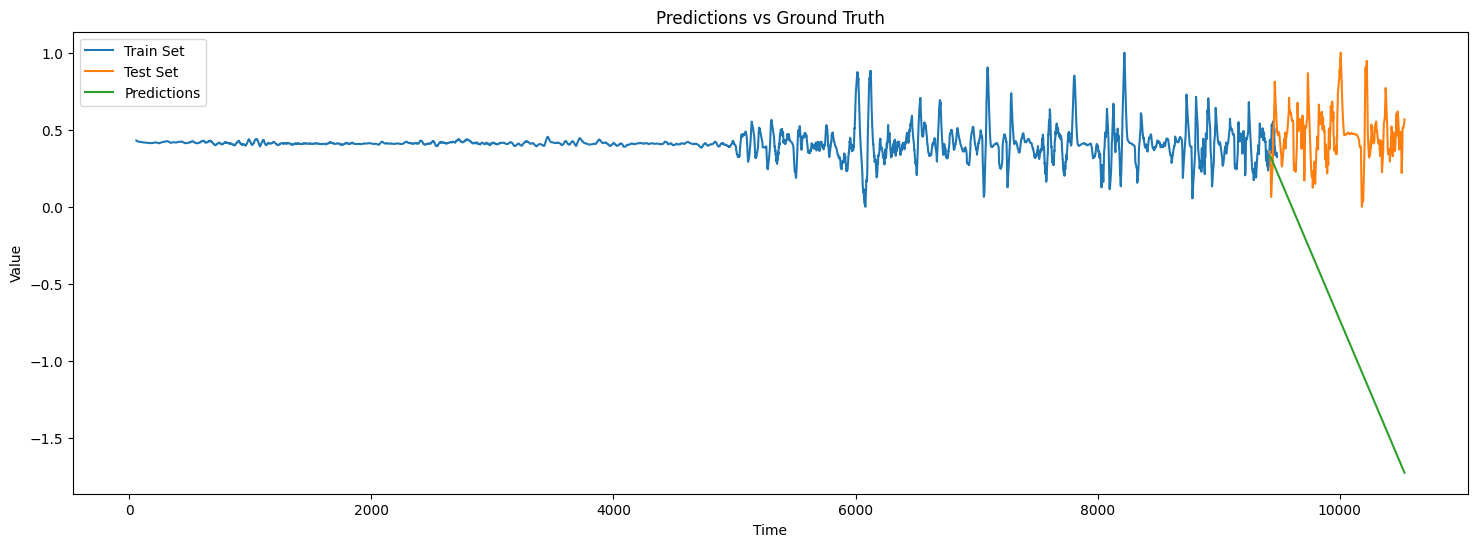

c:\Users\Bl1tty\Documents\Uni\temporales\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Bl1tty\Documents\Uni\temporales\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Bl1tty\Documents\Uni\temporales\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Test RMSE: 0.401


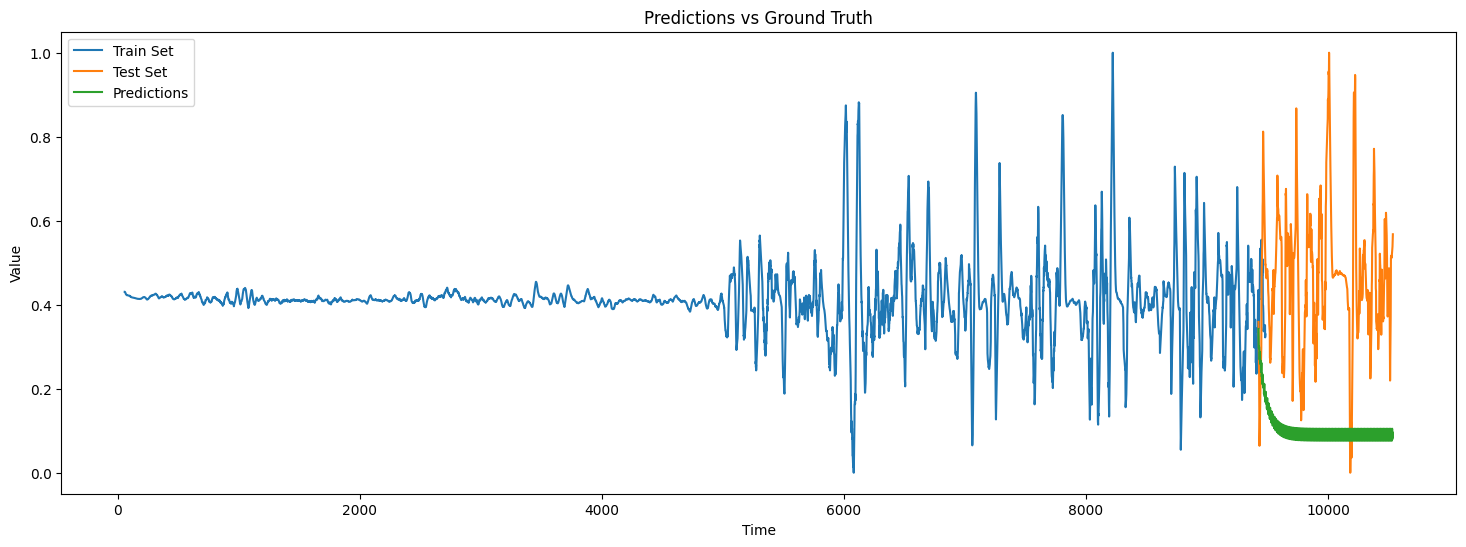

In [12]:
# Import the required libraries
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ARIMA model
model_arima = ARIMA(y_train, order=(3,2,10))
model_arima_fit = model_arima.fit()

# Make predictions
predictions_arima = model_arima_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
plot_and_validate(y_train, y_test, predictions_arima)

# SARIMA model
model_sarima = SARIMAX(y_train, order=(1,0,1), seasonal_order=(1, 1, 0, 12))
model_sarima_fit = model_sarima.fit()

# Make predictions
predictions_sarima = model_sarima_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
plot_and_validate(y_train, y_test, predictions_sarima)

## Prophet Demonstration

20:53:08 - cmdstanpy - INFO - Chain [1] start processing
20:53:09 - cmdstanpy - INFO - Chain [1] done processing


RMSE for Prophet: 0.19
Test RMSE: 0.189


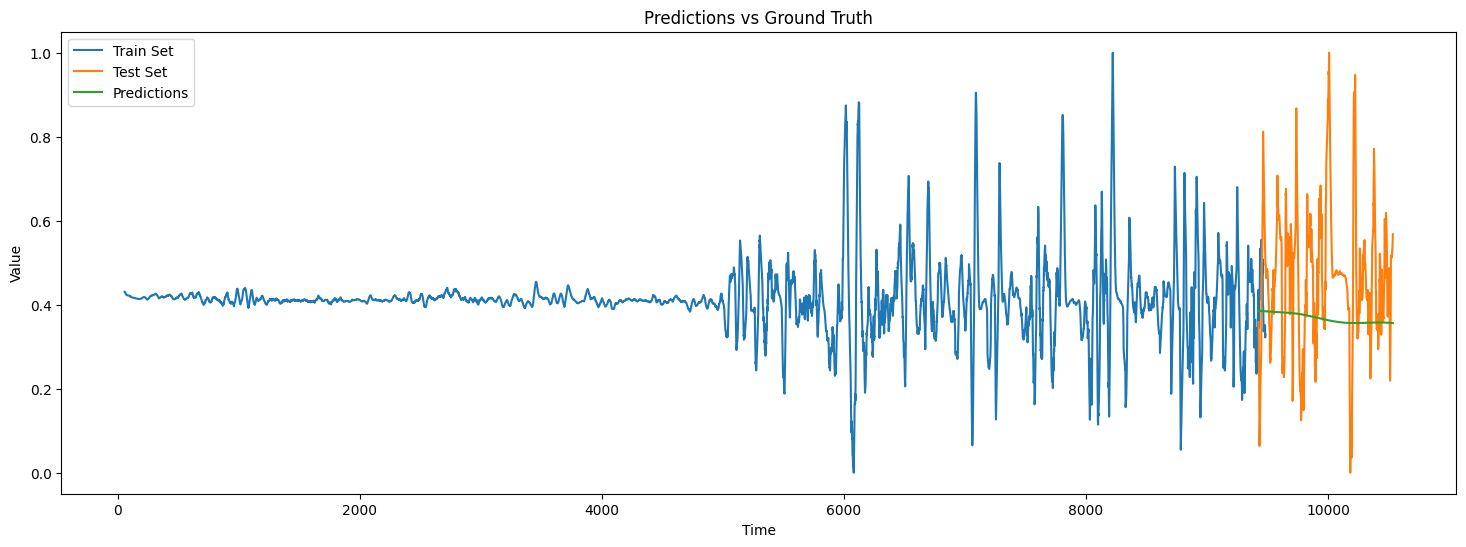

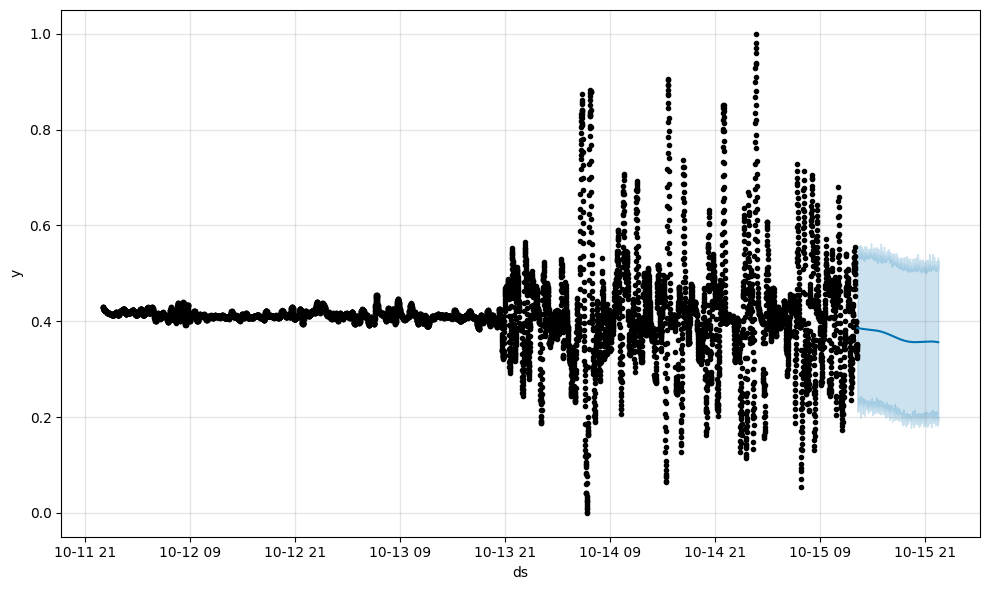

In [18]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt

def create_features(df):
    df['lag_1'] = df['moisture_ground'].shift(1)
    df['rolling_mean'] = df['moisture_ground'].rolling(window=3).mean()
    return df.dropna()

# Preprocess the training data
train_df_prophet = create_features(train_df)

# Initialize the Model with tuned hyperparameters
model_prophet = Prophet(
    interval_width=0.95,
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10.0,
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
)

# Prepare the training data
new_df = train_df_prophet.reset_index().rename(columns={'index': 'ds', 'moisture_ground': 'y'})
new_df['ds'] = pd.to_datetime(new_df['timestamp'], unit='s')

# Fit the Model
model_prophet.fit(new_df)

# Make Future DataFrame
future = model_prophet.make_future_dataframe(periods=len(y_test), freq='30s', include_history=False)

# Make Predictions
forecast = model_prophet.predict(future)

# Extract Predicted Values
predictions_prophet = forecast['yhat'].values[-len(y_test):]

# Calculate RMSE for Prophet
rmse_prophet = sqrt(mean_squared_error(y_test, predictions_prophet))
print(f"RMSE for Prophet: {rmse_prophet:.2f}")

plot_and_validate(y_train, y_test, predictions_prophet)

# Use the plot with confidence intervals
_ = model_prophet.plot(forecast)

## Prophet ensemble

20:55:09 - cmdstanpy - INFO - Chain [1] start processing
20:55:11 - cmdstanpy - INFO - Chain [1] done processing
20:55:12 - cmdstanpy - INFO - Chain [1] start processing
20:55:12 - cmdstanpy - INFO - Chain [1] done processing


RMSE for Ensemble Model: 0.18
Test RMSE: 0.182


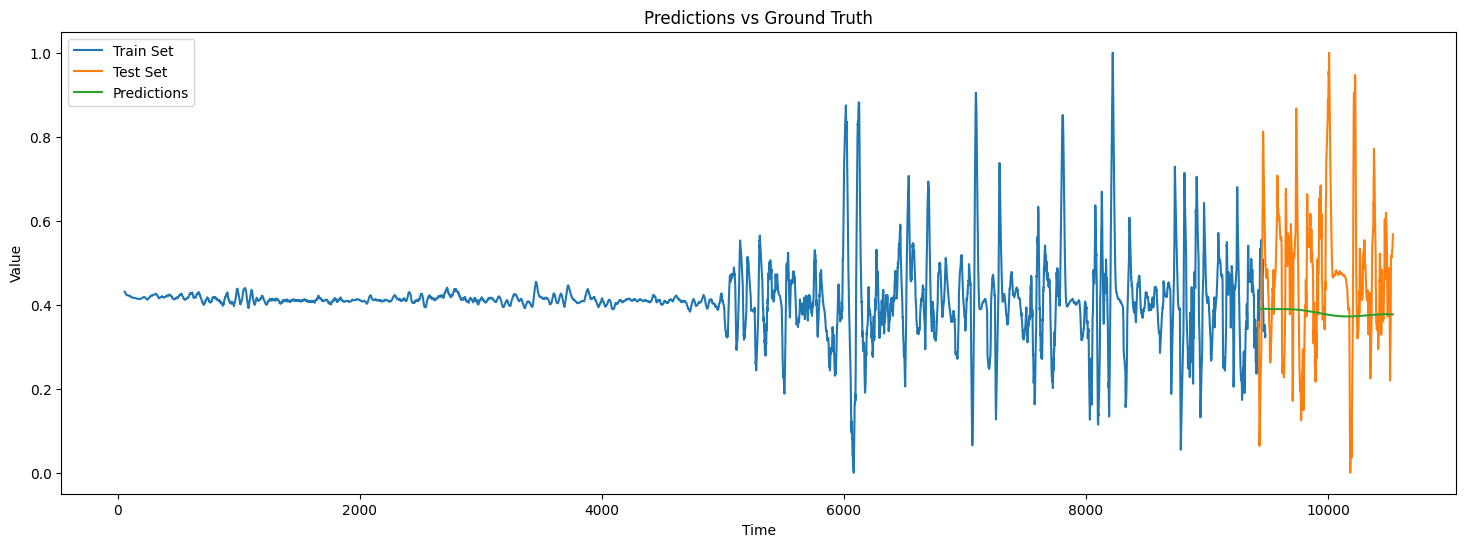

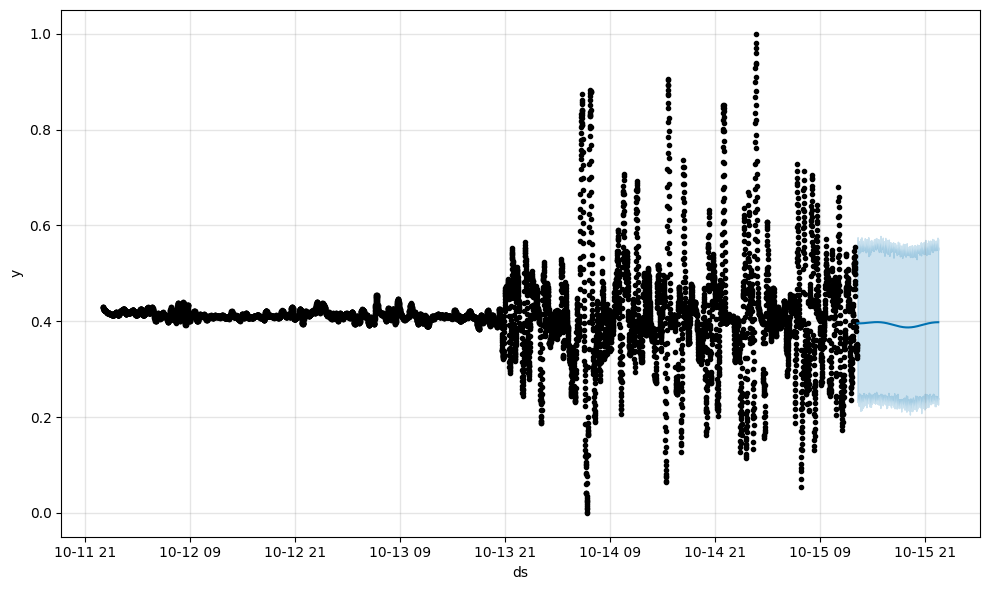

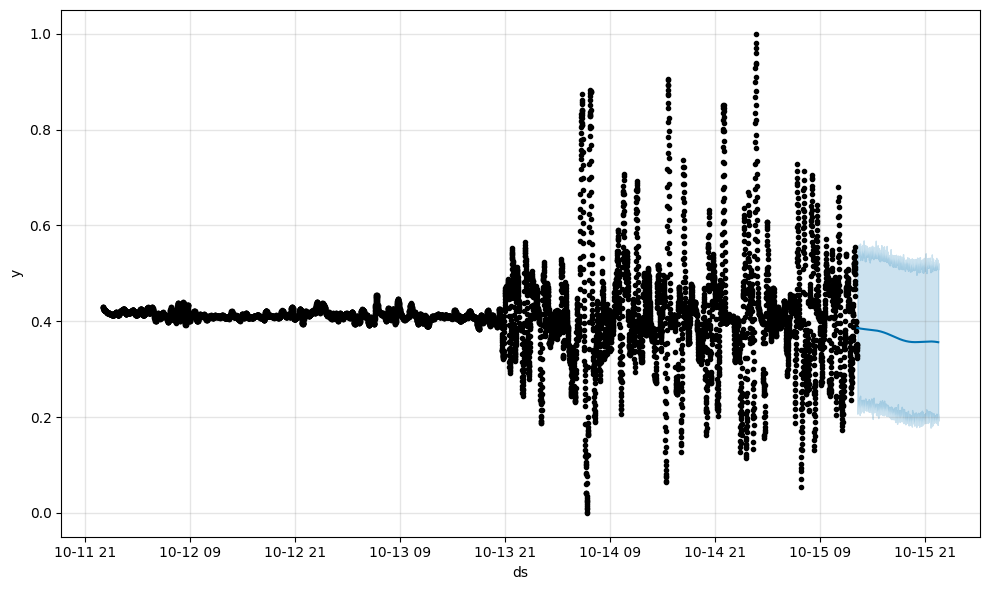

In [20]:
# Initialize the first Prophet Model with default hyperparameters
model_prophet_1 = Prophet(interval_width=0.95)
new_df_1 = train_df_prophet.reset_index().rename(columns={'index': 'ds', 'moisture_ground': 'y'})
new_df_1['ds'] = pd.to_datetime(new_df_1['timestamp'], unit='s')
model_prophet_1.fit(new_df_1)

# Initialize the second Prophet Model with optimized hyperparameters
model_prophet_2 = Prophet(
    interval_width=0.95,
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10.0,
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
)
new_df_2 = train_df_prophet.reset_index().rename(columns={'index': 'ds', 'moisture_ground': 'y'})
new_df_2['ds'] = pd.to_datetime(new_df_2['timestamp'], unit='s')
model_prophet_2.fit(new_df_2)

# Make Future DataFrame
future = model_prophet_1.make_future_dataframe(periods=len(y_test), freq='30s', include_history=False)

# Make Predictions using the first model
forecast_1 = model_prophet_1.predict(future)
predictions_prophet_1 = forecast_1['yhat'].values[-len(y_test):]

# Make Predictions using the second model
forecast_2 = model_prophet_2.predict(future)
predictions_prophet_2 = forecast_2['yhat'].values[-len(y_test):]

# Ensemble Predictions
predictions_ensemble = (predictions_prophet_1 + predictions_prophet_2) / 2

# Calculate RMSE for the ensemble model
rmse_ensemble = sqrt(mean_squared_error(y_test, predictions_ensemble))
print(f"RMSE for Ensemble Model: {rmse_ensemble:.2f}")

plot_and_validate(y_train, y_test, predictions_ensemble)

# Use the plot with confidence intervals
_ = model_prophet_1.plot(forecast_1)
_ = model_prophet_2.plot(forecast_2)

## Random Forest

In [23]:
from sklearn.ensemble import RandomForestRegressor

# Define the model
model_rf = RandomForestRegressor(n_estimators=500, random_state=0)

sliding_window = 48
# Prepare train data
slide_train_df = pd.DataFrame()
for i in range(sliding_window+1):
    for column in train_df.columns:
        slide_train_df[f'{column}-{i}'] = train_df[column].shift(i)

slide_train_df.dropna(inplace=True)
slide_train_df_shuffled = slide_train_df.sample(frac=1, random_state=0)
slide_train_df_x = slide_train_df_shuffled.iloc[:,2:]
slide_train_df_y = slide_train_df_shuffled.iloc[:,:2]

# Fit the model
model_rf.fit(slide_train_df_x.values, slide_train_df_y.values)

# Generate predictions
test_inputs = slide_train_df.iloc[-1, 2:].values.reshape(1, -1)
prediction_rf = []
for i in range(len(test_df)):
    prediction = model_rf.predict(test_inputs)
    prediction_rf.append(prediction)
    test_inputs = np.roll(test_inputs, 2)
    test_inputs[0, :2] = prediction

# prediction_rf = scaler.inverse_transform(np.array(prediction_rf).reshape(-1, 2))


ValueError: Found array with dim 3. None expected <= 2.

In [25]:
prediction_rf # TODO : porque tiene dos outputs? XD

[array([[0.52322289, 0.32847553]]),
 array([[0.51978703, 0.77973105]]),
 array([[0.71825614, 0.43270792]]),
 array([[0.58546669, 0.60341457]]),
 array([[0.41911193, 0.52512157]]),
 array([[0.67589536, 0.46068855]]),
 array([[0.50981915, 0.66678483]]),
 array([[0.54735612, 0.60779687]]),
 array([[0.61419539, 0.41815701]]),
 array([[0.53119284, 0.65919928]]),
 array([[0.61965017, 0.48681904]]),
 array([[0.62450845, 0.53689843]]),
 array([[0.48571135, 0.61991831]]),
 array([[0.60107427, 0.53927676]]),
 array([[0.52132957, 0.6027489 ]]),
 array([[0.5058408 , 0.62965942]]),
 array([[0.61499913, 0.48494509]]),
 array([[0.57570795, 0.60639014]]),
 array([[0.57692081, 0.53533873]]),
 array([[0.61930955, 0.48557071]]),
 array([[0.50963133, 0.60710907]]),
 array([[0.53680351, 0.57751478]]),
 array([[0.5553162, 0.5807577]]),
 array([[0.5154165 , 0.61116015]]),
 array([[0.59734375, 0.49844075]]),
 array([[0.57757844, 0.53255219]]),
 array([[0.57872189, 0.5516428 ]]),
 array([[0.59834145, 0.4971905

In [24]:
plot_and_validate(y_train, y_test, prediction_rf)

ValueError: Found array with dim 3. None expected <= 2.

## VAR

In [33]:
y_train

58      0.430707
59      0.430777
60      0.430632
61      0.430221
62      0.429684
          ...   
9478    0.351553
9479    0.350364
9480    0.322253
9481    0.327112
9482    0.329317
Name: moisture_ground, Length: 9425, dtype: float64

In [34]:
from aeon.forecasting.var import VAR

forecaster = VAR()  
forecaster.fit(y=y_train, X=X_train)  

y_pred = forecaster.predict(fh=len(y_test))  

ValueError: y must have two or more variables, but found only one